# QUANTIFYING MODEL RISK OF RISK MODELS


Paris 1 Panthéon-Sorbonne

#### Notre base de donnée est constituée des rendements journaliers sur ces 2 dernières années (nous ne pouvions pas importer 3 années) du cours de l'entreprise Veolia, une multinationale française qui est spécialisée dans la gestion, l’optimisation et la valorisation des ressources en eau et en énergie. 
#### Les variables sont alors : Ref = reference du cours (Veolia), La date (journaliere), Le prix de l'action, Le rendement de l'action et le volume




In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from scipy.stats import norm
import random
import scipy
from stochastic.continuous import FractionalBrownianMotion
import pywt
from scipy.stats import gaussian_kde
from scipy import stats

In [130]:
url="C:/Users/louis/Downloads/"

In [131]:
db = pd.read_csv(url+"DG.csv", sep=";")
print(db.head())
db["Date"]=pd.to_datetime(db["Date"])
db["Rendements"]=db["Rendements"].replace(",",".",regex=True)
db["Rendements"]=db["Rendements"].replace("%","",regex=True)
db["Rendements"]=db["Rendements"].astype(float)
db["Prix_Action"]=db["Prix_Action"].replace(",",".",regex=True)
db["Prix_Action"]=db["Prix_Action"].astype(float)

            Ref        Date Prix_Action Rendements   Volume
0  FR0000125486  01/03/2018          81      0,00%  1634512
1  FR0000125486  02/03/2018       79,42     -1,95%  1955518
2  FR0000125486  05/03/2018       78,76     -0,83%  1205915
3  FR0000125486  06/03/2018        80,6      2,34%  1181287
4  FR0000125486  07/03/2018        79,5     -1,36%  1268385


In [132]:
db.head()
#db["Rendements"] = db["Rendements"] *100

,Ref,Date,Prix_Action,Rendements,Volume
0,FR0000125486,2018-01-03,81.00,0.00,1634512
1,FR0000125486,2018-02-03,79.42,-1.95,1955518
2,FR0000125486,2018-05-03,78.76,-0.83,1205915
3,FR0000125486,2018-06-03,80.60,2.34,1181287
4,FR0000125486,2018-07-03,79.50,-1.36,1268385


C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Valeur des rendements en %')

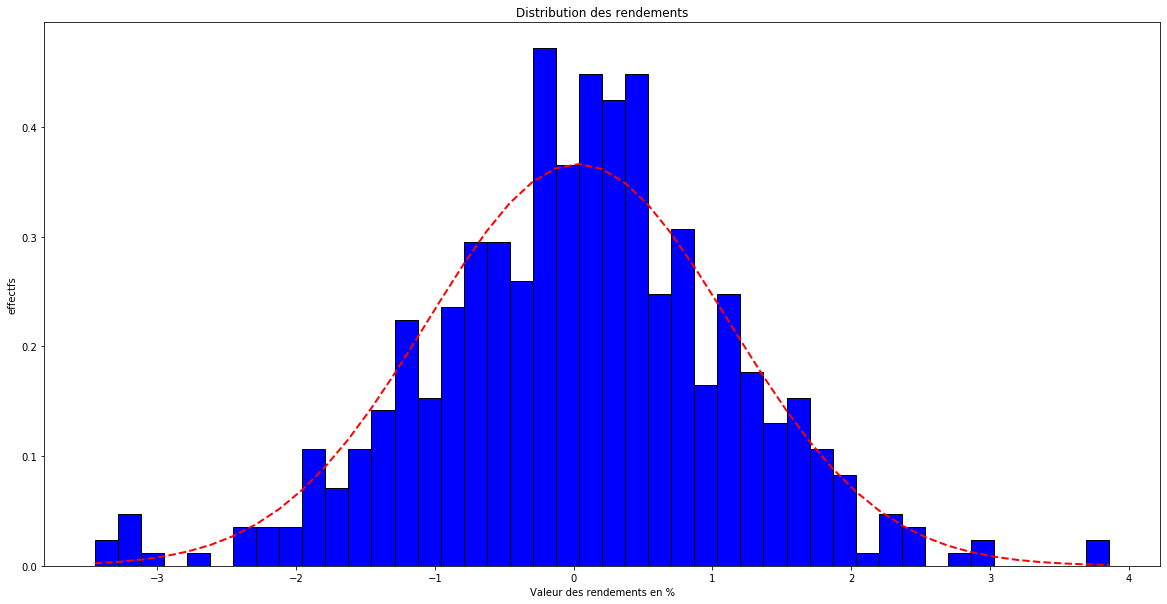

In [133]:
plt.figure(figsize=(20,10)) 
(mu, sigma) = norm.fit(db['Rendements'])
n, bins, patches = plt.hist(db['Rendements'], normed=1,color = 'blue',edgecolor = 'black',bins = int(220/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des rendements")
plt.ylabel("effectfs")
plt.xlabel("Valeur des rendements en %")

On remarque que la distribution des rendements de notre actif peut s'apparenter à une loi normale de moyenne nulle 


## 1. About various calculation methods for the VaR

#### 1.1 Determine your VaR at 99% at a one-day horizon using alternatively the following methods:. empirical quantile,. parametric distribution,. nonparametric distribution.

La VaR est un outil fort utile qui nous permet de mesurer la quantité mimale de perte à laquelle on est confronté pour un intervalle de confiance donné. Mais la limite est que l'on ne connaît pas la tendance des distributions de pertes en dessous de son niveau

###### Empirical quantile

In [134]:
tri=db.sort_values(by=["Rendements"])
tri.head()

,Ref,Date,Prix_Action,Rendements,Volume
507,FR0000125486,2020-02-26,98.00,-3.45,2165716
169,FR0000125486,2018-10-29,75.12,-3.30,998384
509,FR0000125486,2020-02-28,92.64,-3.24,3825260
197,FR0000125486,2018-06-12,73.58,-3.24,2541701
198,FR0000125486,2018-07-12,71.24,-3.18,1821018


In [135]:
NR=0.01
min=int(round(db.shape[0]*NR,0))
print(tri.iloc[min,3])

-3.16


D'après nos données empiriques, nous avons 1% de chance d'avoir une perte supérieure à -3.15% . Pour une si faible probabilité, cette perte est relativement faible, et devrait être supportable par Véolia.

###### Parametric distribution

Text(0.5, 1.0, 'Distribution des rendements')

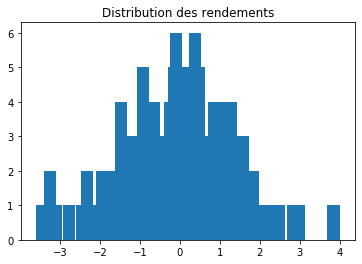

In [136]:
a=db.groupby("Rendements")["Rendements"].agg({"count"}).reset_index()
plt.bar(a["Rendements"],a["count"],width=0.3)
plt.title("Distribution des rendements")

In [137]:
VaR = np.mean(db["Rendements"]) - 2.32 * np.std(db["Rendements"])
print(round(VaR,2))

-2.49


La VaR paramètrique est plus généreuse que la VaR empire. On aurait 99% de chances de faire un gain supérieur à -2,5%

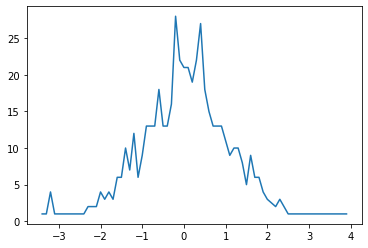

In [138]:
b=deepcopy(a)
b["Rendements"]=round(b["Rendements"],1)
b=b.groupby("Rendements")["count"].agg({"sum"}).reset_index()
plt.plot(b["Rendements"],b["sum"])

###### nonparametric distribution

In [139]:
valeur = 1000000
simulation = np.random.normal(np.mean(db["Rendements"]), np.std(db["Rendements"]), valeur)
Mte_carlo_VaR = np.percentile(simulation, 1)
Mte_carlo_VaR

-2.5018016994645804

Les résultats de la VaR non paramétriques sont assez similaires à ceux de la loi paramétrique

In [140]:
print("Resulat VaR historique : {}" .format(str(round(tri.iloc[min,3],2))))
print("Resulat VaR paramétrique : {}" .format(str(round(VaR,2))))
print("Resulat VaR non paramétrique : {}" .format(str(round(Mte_carlo_VaR,2))))

Resulat VaR historique : -3.16
Resulat VaR paramétrique : -2.49
Resulat VaR non paramétrique : -2.5


La VaR 99% est la perte maximale possible avec une probabilité de 1% de survenance pour un horizon donné (1 jours énoncé).
Pour la calculer, on peut utiliser les données historiques. Cela impose comme limite de supposer que l'évolution de nos rendements n'ont pas de trend au cours du temps. (Une perte de 3% en 1980 est-elle équivalente à une perte de 3% en 2020?).
On peut également supposer la distribution de nos rendements comme normale. Au vu de la représentation graphique de nos rendements, cette hypothèse ne semble pas farfelue. Dans ce cas précis, nous la préfèrons. Si l'on sait que la distribution ne suit aucune loi, des approches non paramétriques sont à privilégier. Nous allons ci-dessous calculer l'estimateur de Pickands.


###### 1.2 Using the estimator of Pickands, determine the parameter of the GEV function of losses. Comment its value.

L'estimateur de Pickands se détermine de la façon suivante : 


\begin{align}
\ Pickand Estimator  :\xi_{P}^{k,n} = \frac{1}{ln2}*ln(\frac{X_{k,n} - X_{2k,n}}{X_{2k,n} - X_{4k,n}})
\end{align}


L'estimateur de pickand est un estimateur de l'indice de queue. Plus cet indice sera élevé en valeur absolu, plus les valeurs extrêmes seront importantes.

Celui-ci se calcul avec un paramètre k qui représente un décalage. Ce décalage fixe sera le plus important que k sera fort. 
En effet, nous avons créer pour le calculer 3 indices,
si k=2 : 
alors l'indice 1 prendra la poistion 509, l'indice 2 prendra la place 507 et l'indice 4 prendra la place 495. 
Les données étant triées dans un ordre décroissant, alors l'estimateur de pickands sera calculé sur les rendements négatifs les plus élevés.
A contrario, si k=40 : 
Indice 1 : 471 position / Indice 2 :431 / Indice 3 : 351
Ainsi, plus k sera élevé, plus l'estimateur de Pickand sera faible.

l'estimateur de Pickand nous servira, à la question suivante, à calucler la VaR grâce à l'EVT

In [141]:
def pickands(data,k):
    temp=data.sort_values(by=["Rendements"],ascending=False).reset_index()
    ordered_data=temp.Rendements
    n= len(ordered_data)
    indice_k= ordered_data[n-k+1]
    indices_2k = ordered_data[n-2*k+1]
    indices_4k = ordered_data[n-4*k+1]
    estimateur_pickands = (1./np.log(2)) * np.log((indice_k - indices_2k) / (indices_2k - indices_4k))
    print("l'estimateur de pickands prend la valeurs de: " + str(round(estimateur_pickands,2)))
    return estimateur_pickands
pickands(db,5)

l'estimateur de pickands prend la valeurs de: 0.66


0.6599245584023776

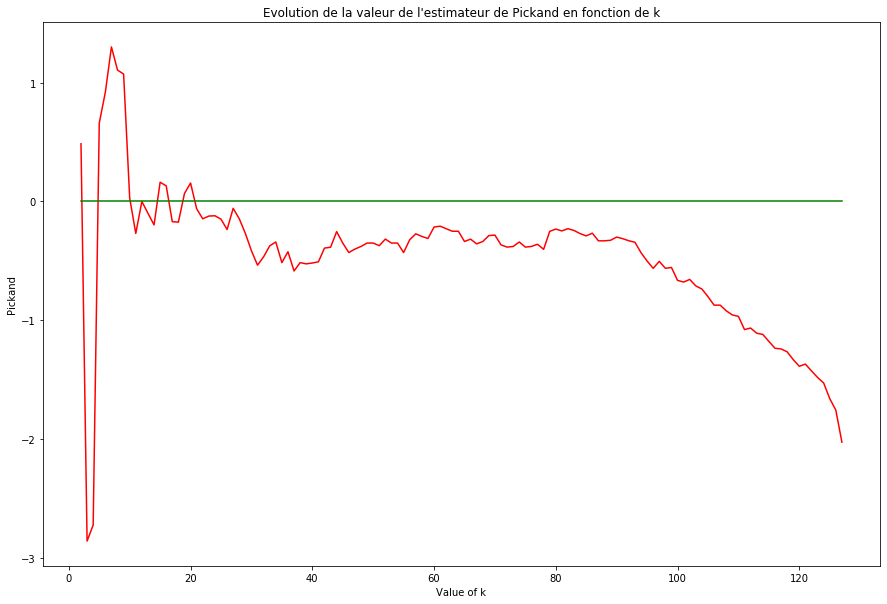

In [142]:
pick = []
valeur0=[]
kvalues =[]
n= len(db)
for k in range(2,128):
    temp=db.sort_values(by=["Rendements"],ascending=False).reset_index()
    ordered_data=temp.Rendements
    indice_k= ordered_data[n-k+1]
    indices_2k = ordered_data[n-2*k+1]
    indices_4k = ordered_data[n-4*k+1]
    estimateur_pickands = (1./np.log(2)) * np.log((indice_k - indices_2k) / (indices_2k - indices_4k))
    valeur= 0
    pick.append(estimateur_pickands)
    valeur0.append(valeur)
    kvalues.append(k)
    
plt.figure(figsize=(15,10))
plt.plot(kvalues,pick,c='red')
plt.plot(kvalues, valeur0,c='green')
plt.xlabel('Value of k')
plt.ylabel('Pickand')
plt.title("Evolution de la valeur de l'estimateur de Pickand en fonction de k")
plt.show()


Evolution de la valuer de l'estimation du paramètre de Pickands par rapport à la valeur k. On voit ici que l'estimateur décroit lorsque k tend vers l'infini.

In [143]:
Pickands=pd.DataFrame(list(zip(pick,kvalues)), columns=['Estimateur_Pickland','kvalues'])
Pickands["Estimateur_Pickland"]= round(Pickands["Estimateur_Pickland"],3)
Pickands

,Estimateur_Pickland,kvalues
0,0.485,2
1,-2.858,3
2,-2.722,4
3,0.660,5
4,0.919,6
...,...,...
121,-1.481,123
122,-1.527,124
123,-1.659,125
124,-1.756,126


Si estimateur_pickands < 0, Weibull peut en être une bonne approximation.
Si au dessus, Frechet en sera une meilleure.

L'avantage de l'estimateur de Pickand dans la GEV est le fait que celui-ci soit valable quelle que soit la distribution des extrêmes, que ça soit Gumbel, Weibull ou Fréchet.

##### 1.3 Determine the VaR at 99% at a one-day horizon using the EVT approach.

Le but est ici de déterminer la Value at risk d’une nouvelle manière non paramétrique. 
Cette VaR serait déterminée à l’aide de l’EVT (Extreme Theory Value), cependant pour l’utiliser, nous avons besoin de l’estimateur de Pickands. 
La théorie des valuers extrêmes permet, sous des conditions de régularité très générales, de modéliser les probas extrêmes par 3 lois.  

On peut voir ci-dessous la distribution de ces 3 lois: 



<p align="center">
<img width="540" height="350" src="http://www.dataanalysisclassroom.com/wp-content/uploads/2018/04/types_dist_lesson59.png">
</p>


On voit dans notre cas, que nous sommes dans un cas de Weibull pour déterminer la VaR à 99 %.

De cette courbe ne Weibull, nous pouvons déterminer la VaR. Cette VaR sera calculée par l'estimateur.
Cependant il est important de noter que l'estimateur dans le cas de Weibull doit être strictement néhgatif. Nous appliquons donc une petite boucle if pour régler ce problème étant donné le peut de valeur positive qu'on ait pour Pickand.

The VaR using the Pickand estimator:

\begin{align}
\ VaR(p) = \frac{(\frac{k}{n(1-p)})^{\xi^{P}}-1}{1-2^{-\xi^{P}}}(X_{n-k+1:n} - X_{n-2k+1:n}) + X_{n-k+1:n}
\end{align}

where the Pickand estimateur is the GEV one.

In [144]:
def EVT(data,k,p):
    temp=data.sort_values(by=["Rendements"],ascending=False).reset_index()
    ordered_data=temp.Rendements
    estimateur = pickands(data,k)
    n=len(ordered_data)
    if estimateur > 0 : 
        val = (estimateur)
    else : 
        val = (-estimateur)
    VaRpickand = ((((k/(n*(1-p)))**(val))-1) / (1-2**(-val)) ) *(ordered_data[n-k+1] - ordered_data[n-2*k+1]) + ordered_data[n-k+1]
    return VaRpickand
VaRpick = EVT(db,3,0.99)
print('La VAR à 99% est de {}'.format(str(round(VaRpick, 2))+"%"))

l'estimateur de pickands prend la valeurs de: -2.86
La VAR à 99% est de -3.19%


Ainsi, en utilisant la formule de la VaR ci-dessus, en fixant le paramètre k à 3 nous obtenons une VaR à 99% de -3.19 %.

Nous décidons ici de modéliser la VaR associée aux differents paramètres de k. 
Nous savons que l'estimateur de Pickand est particulièrement peu stable, et que son paramètre k est compliqué à fixer. Par conséquent nous avons voulu observer cette volatilité de la VaR par la variation des paramètres k.

In [145]:
k_value = []
VaRpickand_est = []
for k in range(2,127) : 
    VaRpickand= EVT(db,k,0.99)
    k_value.append(k)
    VaRpickand_est.append(VaRpickand)

l'estimateur de pickands prend la valeurs de: 0.49
l'estimateur de pickands prend la valeurs de: -2.86
l'estimateur de pickands prend la valeurs de: -2.72
l'estimateur de pickands prend la valeurs de: 0.66
l'estimateur de pickands prend la valeurs de: 0.92
l'estimateur de pickands prend la valeurs de: 1.3
l'estimateur de pickands prend la valeurs de: 1.11
l'estimateur de pickands prend la valeurs de: 1.07
l'estimateur de pickands prend la valeurs de: 0.03
l'estimateur de pickands prend la valeurs de: -0.27
l'estimateur de pickands prend la valeurs de: -0.0
l'estimateur de pickands prend la valeurs de: -0.1
l'estimateur de pickands prend la valeurs de: -0.2
l'estimateur de pickands prend la valeurs de: 0.16
l'estimateur de pickands prend la valeurs de: 0.13
l'estimateur de pickands prend la valeurs de: -0.17
l'estimateur de pickands prend la valeurs de: -0.17
l'estimateur de pickands prend la valeurs de: 0.07
l'estimateur de pickands prend la valeurs de: 0.16
l'estimateur de pickands pr

Text(0.5, 1.0, 'Evolution des VaR_99% en fonction du paramètre k')

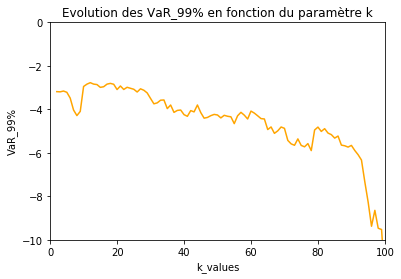

In [146]:
visu=pd.DataFrame(list(zip(k_value,VaRpickand_est)), columns=['k_value','VaRpickand_est'])
visu["VaRpickand_est"]= round(visu["VaRpickand_est"],3)
plt.plot(visu["k_value"],visu["VaRpickand_est"], color= "orange")
plt.xlim(0,100)
plt.ylim(-10,0)
plt.xlabel("k_values")
plt.ylabel("VaR_99%")
plt.title("Evolution des VaR_99% en fonction du paramètre k")

On constate bien ici que la VAR calculée à 99% dépend bien du k choisi. En effet, plus celui-ci sera élevé moins il paraitra plausible 

#### 1.4  What is Leadbetter's extremal index for the dataset? Comment its value and explain how you should change your VaR to take this into account (only provide an explanation, with equations, do not calculate a new VaR).

l'extremal index est un paramètre qui mesure le nombre de clusters dépassant un certain seuil de pertes fixées dans un processus stationnaire. Ce paramètre varie entre 0 et 1. Plus il s'approche de 1, moins il y a effet de cluster dans nos données extrèmes. Le paramètre seuil doit être négatif, on cherche à comptabiliser le nombre de cluster enregistrant plus de pertes que ce seuil. Le b est la taille du cluster 

In [147]:
def Leadbetter(data,b,seuil):
    n=len(data)
    k = int(n/b)
    value = data.Rendements.values 
    somme_value = sum((value < seuil)) #on prend inférieur car on s'intéresse à nos pertes (inférieur négativement)
    somme_cluster = []
    for i in np.arange(1,k+1):
        a= (i-1)*b
        z= i * b
        n= value[a-1:z]
        if len(n) != 0:
            somme_cluster.append(max(value[a-1:z]) > seuil)
    Leadbetter_index = sum(somme_cluster)/somme_value
    return print(" la valeur de l'indice extrêmal de Leadbetter est de: {} ".format(str(round(Leadbetter_index,3))))
Leadbetter(db,8,-0.03)

 la valeur de l'indice extrêmal de Leadbetter est de: 0.254 


nos pertes sont relativement peu regroupées dans des clusters. Cela signifie qu'il n'y a pas forcement beaucoup d'autocorrélation entre elles

#### 1.5 ) What is a Hurst exponent and how can one interpret its value?

L"Hurt exponent" est utilisé pour mesurer la mémoire de long-terme d'une série. C'est une mesure relative à l'autocorrélation des chocs browniens dans les séries temporelles. Un choc brownien est totalement aléatoire. Il intervient dans des modèles de pricings courant (de type Black&Scholes). l'Hurt expnonent mesure donc la corrélation dans le temps de ces chocs aléatoires sur le processus gaussien. On peut le déterminer par l'implémentation d'une méthode R/S (so-called rescaled range).
La valeur varie entre 0 et 1, si il est supérieur à 0.5 signifie qu'il y a une autocorrélation positive de long terme. Un choc brownien positif sera probablement suivi d'un autre. Si il est égal à 0.5, il n'y a pas d'autocorrélation. Si il est inférieur à 0.5, l'autocorrélation sera positive ou négative mais de court terme.

The Hurst exponent, H est défini comme ceci:

\begin{align}
\ {\displaystyle \mathbb {E} \left[{\frac {R(n)}{S(n)}}\right]=Cn^{H}{\text{ as }}n\to \infty \,,}
\end{align}


Avec n: le nombre d'observation de la série temporelle. 
R(n): Le range du nième écart à la moyenne, et S(n) leur écart-type et
C est une constante

#### 1.6 ) Propose a risk measure taking into account the Hurst exponent and calculate its value for the price series used in this project. The Hurst exponent must be estimated with the absolute-moment estimator. This risk measure must take into account the autocovariance of a fBm (like in the Nuzman-Poor approach for predictions).

A méditer

##  2 From VaR to ES

#### 2.7 ) For each of the methods exposed above for calculating VaR, expose a method to extend them to ES. Calculate the 99% ES on the same sample.

Petit rappel de nos VaR obtenues:
Le calcul de la VaR nous permet de déterminer le seuil au-dessus du quel 99% des rendements seront supérieurs. Cependant dans 1%¨des cas en théorie, les rendements seront inférieurs au seuil calculé par la VaR. 

In [148]:
print(tabulate([[str(round(tri.iloc[min,3],2))+"%",str(round(VaR,2))+"%",str(round(Mte_carlo_VaR,2))+"%",str(round(VaRpick, 2))+"%"]],headers=
     ["VAR 99% empirique","VAR 99% paramétrique","VAR 99% non paramétrique","VAR 99% par estimateur de Pickands"]))

VAR 99% empirique    VAR 99% paramétrique    VAR 99% non paramétrique    VAR 99% par estimateur de Pickands
-------------------  ----------------------  --------------------------  ------------------------------------
-3.16%               -2.49%                  -2.5%                       -3.19%


Formule de l'ES:

<p align="center">
<img width="540" height="350" src="https://meritis.fr/wp-content/uploads/2017/09/Formule-Horizon-temporel-comme-pour-la-VaR-1024x85.png">
</p>


L'ES mesure la moyenne de la distribution des pertes en dessous du niveau de la VaR. Autrement dit, si on a une VaR de -1%, l'ES associé à cette VaR mesurera le niveau moyen des pertes en dessous de ce niveau de rendement

In [149]:
VaR_trouvées=[round(tri.iloc[min,3],2),round(VaR,2),round(Mte_carlo_VaR,2),round(VaRpick, 2)]
VaR_trouvées

[-3.16, -2.49, -2.5, -3.19]

La VaR présente de nombreuses limites, on ne connaît pas la distribution des pertes en dessous de son seuil. On pourrait très bien avoir des pertes fortement corrélées.
Donc on peut calculer la moyenne sous son rendement pour obtenir une distribution. En effet, il n'y a aucune raison de penser que la distribution des pertes en dessous d'un seuil suivra une distribution paramètrique.

In [150]:
ES = []
VaR_99 = []
for i in VaR_trouvées :
    somme = 0
    for j in db["Rendements"] : 
        if j<i : 
            somme += j
    moy = somme / len(db[db["Rendements"]<i])
    ES.append(moy)
    VaR_99.append(i)
Expected_Shortfall=pd.DataFrame(list(zip(VaR_99,ES)), columns=['VaR_99','ES'])
for i in range(Expected_Shortfall.shape[0]):
    print(f"Pour la VaR fixée à {round(Expected_Shortfall.iloc[i,0],2)}% , l'expected shortfall est de : {round(Expected_Shortfall.iloc[i,1],2)}%")

Pour la VaR fixée à -3.16% , l'expected shortfall est de : -3.28%
Pour la VaR fixée à -2.49% , l'expected shortfall est de : -3.18%
Pour la VaR fixée à -2.5% , l'expected shortfall est de : -3.18%
Pour la VaR fixée à -3.19% , l'expected shortfall est de : -3.31%


Nos moyennes en fonction de nos Var calculées sont relativements proches, cela peut être dû au fait que nous avons peu de données, ou que les niveaux de VaR sont trop proches (surtout pour le paramétrique et le non paramétrique)

#### 2.8 ) Backtest the ESs and the corresponding VaRs on your sample. Pay attention to the strict separation of estimation sample and test sample for this question (for the other questions, simply estimate the risk measures on the whole sample). Comment the result about the relative accuracy of ES and VaR.

Pour Backtester nos ES et VaR nous pourrons procéder à un test de Kupiec

Christffersen (1998) qu'une prÈvision de VaR est valide si et seulement si la séquence des violations fItgTt=1 satisfait les deux hypothèses suivantes:\

-L'hypothèse de couverture non conditionnelle(unconditionalcoverage, UC)\
-L'hypothèse d'indépendance(independence, IND)

Cette loi est vérifiée si :
Si l'on suppose que les variables It(α) sonti.i.d., alors sous l'hypothèse UC le nombre total de violations N suit une loi Binomiale.

Si T est suffisament important, on peut approximer la loi Binomiale par une loi Normale et sous l'hypothèse d'UC il vient :
\begin{align}
\ Z = \frac{N-pT}{(p(1-p)T)^{1/2}} -> N(0,1)
\end{align}

N : données extraordinaires \
p : pourcentage VaR \
T : observations totales

In [151]:
VaR_trouvées=[round(tri.iloc[min,3],2),round(VaR,2),round(Mte_carlo_VaR,2),round(VaRpick, 2)]
VaR_trouvées

[-3.16, -2.49, -2.5, -3.19]

In [152]:
T = len(db)
p = 0.01
réalisation_except = []
VaR_99 = []
for i in VaR_trouvées : 
    N = int(len(db[db["Rendements"]<i]))
    Z = (N-(p*T))/((p*(1-p)*T)**(1/2))
    VaR_99.append(i)
    réalisation_except.append(Z)
stat=pd.DataFrame(list(zip(VaR_99,réalisation_except)), columns=['VaR_99','réalisation_except'])

for i in range(stat.shape[0]):
    if abs(stat.iloc[i,1])>2.32:
        print(f"Pour la VaR fixée à {round(stat.iloc[i,0],2)}% ,H0 rejetté: l'hypothèse d'UC donc la VaR n'est pas valable car > au fractile de la loi normale (2.32)")
    else:
        print(f"Pour la VaR fixée à {round(stat.iloc[i,0],2)}% ,H0 accepé: l'hypothèse d'UC donc la VaR est valable car < au fractile de la loi normale (2.32)")

Pour la VaR fixée à -3.16% ,H0 accepé: l'hypothèse d'UC donc la VaR est valable car < au fractile de la loi normale (2.32)
Pour la VaR fixée à -2.49% ,H0 accepé: l'hypothèse d'UC donc la VaR est valable car < au fractile de la loi normale (2.32)
Pour la VaR fixée à -2.5% ,H0 accepé: l'hypothèse d'UC donc la VaR est valable car < au fractile de la loi normale (2.32)
Pour la VaR fixée à -3.19% ,H0 accepé: l'hypothèse d'UC donc la VaR est valable car < au fractile de la loi normale (2.32)


Le test de couverture inconditionnelle a pour but d’évaluer si la fréquence des exceptions est compatible avec le quantile de la perte que la VaR est censée refléter. 
Soit  N le  nombre  d'exceptions  et T le  nombre  total  d'observations,  nous  pouvons  définir la fréquence des exceptions π= 𝑁/𝑇; idéalement, ce taux devrait refléter le niveau de confiance choisi.

Le  test  de  Kupiec(1995) nous permet  de  vérifier l'hypothèse  nulle  que  la  fréquence  des exceptions 𝜋=𝑁/𝑇 est égale au niveau de signification α que nous utilisons lors du calcul de la VaR.


Loi Chi² à 99% = 6.63

In [153]:
T = len(db)
p = 0.01
réalisation_except = []
VaR_99 = []
for i in VaR_trouvées : 
    N = int(len(db[db["Rendements"]<i]))
    LR = -2*np.log( ((1-p)**(T-N)) * p**N) + 2 *np.log( (1-(N/T))**(T-N) * (N/T)**N )
    VaR_99.append(i)
    réalisation_except.append(LR)
stat2=pd.DataFrame(list(zip(VaR_99,réalisation_except)), columns=['VaR_99','réalisation_except'])

for i in range(stat2.shape[0]):
    if abs(stat2.iloc[i,1])>6.63:
        print(f"Pour la VaR fixée à {round(stat2.iloc[i,0],2)}% ,H0 refusé : l'hypothèse d'UC donc la VaR n'est pas valable car > au fractile (6.63)")
    else:
        print(f"Pour la VaR fixée à {round(stat2.iloc[i,0],2)}% ,H0 accepté: l'hypothèse d'UC donc la VaR est valable car < au fractile (6.63)")

Pour la VaR fixée à -3.16% ,H0 accepté: l'hypothèse d'UC donc la VaR est valable car < au fractile (6.63)
Pour la VaR fixée à -2.49% ,H0 accepté: l'hypothèse d'UC donc la VaR est valable car < au fractile (6.63)
Pour la VaR fixée à -2.5% ,H0 accepté: l'hypothèse d'UC donc la VaR est valable car < au fractile (6.63)
Pour la VaR fixée à -3.19% ,H0 accepté: l'hypothèse d'UC donc la VaR est valable car < au fractile (6.63)


## 3 Model risk as estimation uncertainty

#### 3.9. What is model risk and what are the different natures of model risk?

Le risque de modèle est le risque de faire des pertes à cause du modèle que l'on a choisi.
Par exemple, si l'on pose l'hypothèse de la normalité des rendements alors qu'ils ne le sont pas, les modèles que l'on va entraîner risqueront de nous produire des rendements aléatoires. (la chance peut toujours rapporter)
Il existe différentes natures à ce risque. Choisir le mauvais modèle comme nous avons vu en haut. Le risque de paramètrage: de choisir les mauvais paramètres dans le modèle (donc mauvais modèle). Le risque d'overfitter, de sur-entraîner un modèle mais ne pas pouvoir l'appliquer à d'autres données. Tous les risques sur les données doivent être pris en compte égalements.

Il faut donc faire bien attention à ce type de risque!

#### 3.10. For the parametric VaR, determine the distribution of your parameters and determine, either theoretically or by simulations, the corresponding distribution of VaR (each parameter is a random variable; if we draw a vector of parameters, we have one value for the VaR which is different from the VaR obtained for another drawn vector of parameters).

Nous effectuons ici 100000 tirages avec remises. 
Chacun de ces tirages est un échantillon du jeu de donnée contenant 20 rendements chacun.
De chacun de ces tirages, nous en calculerons une moyenne et un écart-type, qui nous permettra ensuite de calculer la VaR99 associée à chacun de ces tirages.

On pourra ainsi observer la distribution des moyennes, écart-types et VaR de cette série de tirage.

In [154]:
tirage=[]
moyenne_tirage=[]
std_tirage=[]
for i in range(1,100000):
    aléa = db["Rendements"].values
    sampling = random.choices(aléa, k=20)
    moy = np.mean(sampling)
    std = np.std(sampling)
    tirage.append(i)
    moyenne_tirage.append(moy)
    std_tirage.append(std)
random=pd.DataFrame(list(zip(tirage,moyenne_tirage,std_tirage)), columns=['tirage','moyenne_tirage','std_tirage']).set_index("tirage")
random["VaR_99"] = random["moyenne_tirage"] - 2.32 * random["std_tirage"]

In [155]:
random

,moyenne_tirage,std_tirage,VaR_99
tirage,,,
1,-0.1260,0.916495,-2.252270
2,-0.0880,1.223837,-2.927301
3,0.2070,0.962087,-2.025041
4,-0.1125,0.785537,-1.934946
5,0.3345,1.086207,-2.185499
...,...,...,...
99995,-0.0670,1.235618,-2.933633
99996,0.0920,1.084374,-2.423747
99997,-0.1720,1.336071,-3.271685


On peut voir ci-dessous une distribution assez proche de la loi normale de chacun des paramètres.

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 0, 'Valeur des rendements moyens en %')

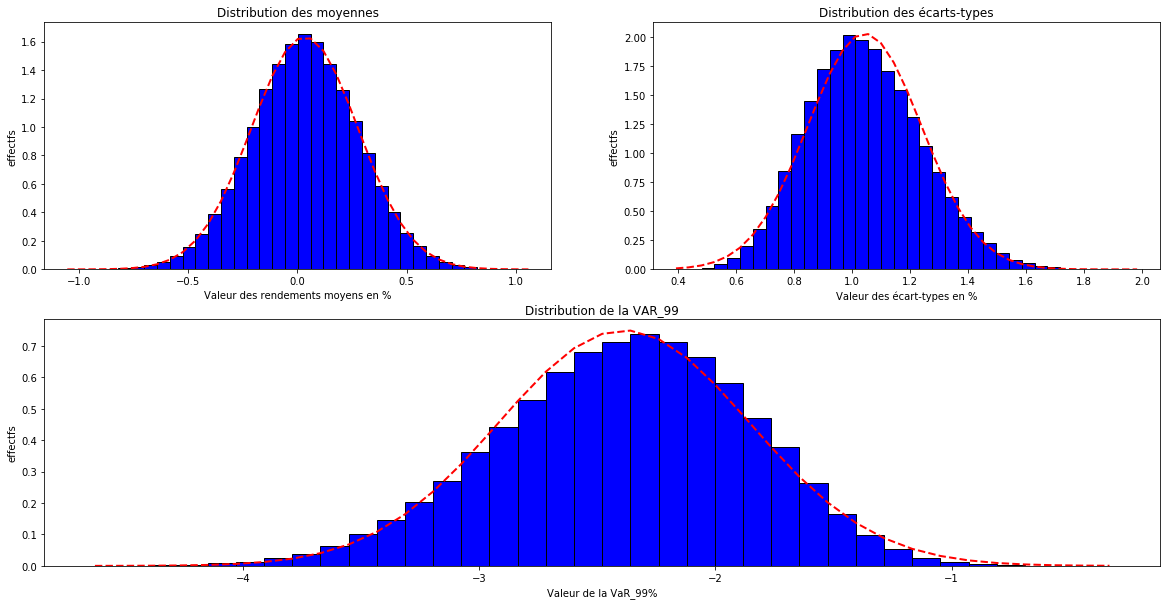

In [156]:
plt.figure(figsize=(20,10)) 

plt.subplot(212)
(mu, sigma) = norm.fit(random['VaR_99'])
n, bins, patches = plt.hist(random['VaR_99'], normed=1,color = 'blue',edgecolor = 'black',bins = int(180/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution de la VAR_99")
plt.ylabel("effectfs")
plt.xlabel("Valeur de la VaR_99%")

plt.subplot(222)
(mu, sigma) = norm.fit(random['std_tirage'])
n, bins, patches = plt.hist(random['std_tirage'], normed=1,color = 'blue',edgecolor = 'black',bins = int(180/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des écarts-types")
plt.ylabel("effectfs")
plt.xlabel("Valeur des écart-types en %")

plt.subplot(221)
(mu, sigma) = norm.fit(random['moyenne_tirage'])
n, bins, patches = plt.hist(random['moyenne_tirage'], normed=1,color = 'blue',edgecolor = 'black',bins = int(180/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des moyennes")
plt.ylabel("effectfs")
plt.xlabel("Valeur des rendements moyens en %")

Ces graphiques sont assez intéressants (si réalisés sur un grand nombre et su un grand jeu de données) pour modéliser la distribution de la VaR. En effet, la VAR 99 qui est le seuil de réalisation sous lequel 1% des pires rendements ont lieu, on peut avoir une idée avec ce graph de quel seuil de VaR il serait judicieux de prendre. En effet, on voit que prendre un VaR_99% à -1 serait particulièrement risquée.


Globalement on est assez satisfait de voir que notre VaR suit une distribution normale. On verra par la suite de ce TP que pour un mouvement Brownien cela n'est pas toujours le cas.

#### 3.11. If we suppose that price returns are iid Gaussian variables, determine, with the help of simulations, the distribution of the EVT parameters as well as the corresponding distribution of VaR

Etant donné que nous supposons ici que nos rendements sont gaussiens, nous les crééons donc artificiellement, pour qu'ils puissent suivre du mieux possible une loi Normale. 
Nous appliquons ici la même éthode que précédement, nous créeons 10000 tirages de 500 rendements, crées par le processus Brownien. Ces tirages sort ensuite trieés pour appliquer la calcul de la VaR avec l'estimateur de Pickand. Pour se faire, nous recalculons notre estimateur de Pickand pour chacun des tirages et l'insérons ensuite dans la formule de la VaR.

In [157]:
import random
tirage=[]
Pickands_est=[]
Var_Pick=[]
k=4
mu, sigma = 0, 1
aléa = np.random.normal(mu, sigma, 100000)
for i in range(1,10000):
    sampling = random.choices(aléa, k=400)
    sampling = sorted(sampling,reverse=True)
    n= len(sampling)
    p=0.99
    indice_k= sampling[n-k+1]
    indices_2k = sampling[n-2*k+1]
    indices_4k = sampling[n-4*k+1]
    estimateur_pickands = (1/np.log(2)) * np.log((indice_k - indices_2k) / (indices_2k - indices_4k))
    if estimateur_pickands > 0 : 
        val = (estimateur_pickands)
        VaRpickand = ((((k/(n*(1-p)))**(val))-1) / (1-2**(-val)) ) *(indice_k - indices_2k) + indice_k
    else : 
        val = (-estimateur_pickands)
        VaRpickand = ((((k/(n*(1-p)))**(val))-1) / (1-2**(-val)) ) *(indice_k - indices_2k) + indice_k
    tirage.append(i)
    Var_Pick.append(VaRpickand)
    Pickands_est.append(estimateur_pickands)
    
random=pd.DataFrame(list(zip(tirage,Pickands_est,Var_Pick)), columns=['tirage','Pickands_est','Var_Pick'])

In [158]:
random

,tirage,Pickands_est,Var_Pick
0,1,1.051445,-2.679513
1,2,0.960854,-2.571740
2,3,-0.478582,-2.438596
3,4,1.021683,-2.765651
4,5,-0.477695,-2.556158
...,...,...,...
9994,9995,0.483824,-2.786821
9995,9996,-0.853530,-2.083840
9996,9997,-0.401669,-2.756574
9997,9998,-1.624519,-2.676370


C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Valeur des VaR en %')

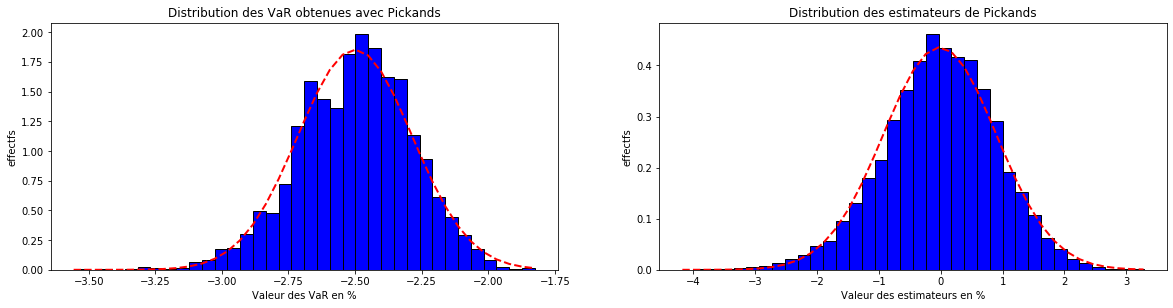

In [159]:
plt.figure(figsize=(20,10)) 


plt.subplot(222)
(mu, sigma) = norm.fit(random['Pickands_est'])
n, bins, patches = plt.hist(random['Pickands_est'], normed=1,color = 'blue',edgecolor = 'black',bins = int(180/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des estimateurs de Pickands")
plt.ylabel("effectfs")
plt.xlabel("Valeur des estimateurs en %")

plt.subplot(221)
(mu, sigma) = norm.fit(random['Var_Pick'])
n, bins, patches = plt.hist(random['Var_Pick'], normed=1,color = 'blue',edgecolor = 'black',bins = int(180/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des VaR obtenues avec Pickands")
plt.ylabel("effectfs")
plt.xlabel("Valeur des VaR en %")

On voit que lorsque les rendements suivent une loi normale, cela s'en ressent dans la distribution des paramètres. En effet, on voit ici qu'il fit plutôt bien une tendance normale

#### 3.12. Apply the same method than the one exposed in Question 11 to determine the distribution of VaR in the fBm case.

Nous simulons ici un mouvement Brownien fractionnaire

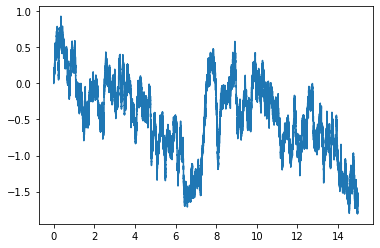

array([ 0.        ,  0.00546545,  0.00366025, ..., -1.67985675,
       -1.67283543, -1.66446978])

In [160]:
fbm = FractionalBrownianMotion(t=15, hurst=0.5) #plus le t est élevé, plus l'intervalle des ordonnées sera large.
# Hurst a 0.5 pour avoir la tendnace la plus neutre possible . Lorsque Hurst=0.5, absence d'autocorrélation.
s = fbm.sample(1000000)
times = fbm.times(1000000)

plt.plot(times, s)
plt.show()
s

Plus le t est élevé, plus l'intervalle des ordonnées sera large.
Hurst a 0.5 pour avoir la tendnace la plus neutre possible . Lorsque Hurst=0.5, absence d'autocorrélation.
Aussi, en théorie, le mouvement Brownien fractionnaire est censé avoir une espérance égale à 0.

Il nous livre une distribution telle que :

Text(0.5, 0, 'Valeur de la VaR_99%')

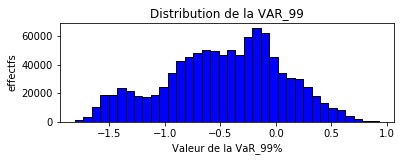

In [161]:
plt.subplot(212)
plt.hist(s, color = 'blue', edgecolor = 'black',bins = int(180/5))
plt.title("Distribution de la VAR_99")
plt.ylabel("effectfs")
plt.xlabel("Valeur de la VaR_99%")

Nous appliquons ici la même éthode que précédement, nous créeons 10000 tirages de 500 rendements, crées par le processus Brownien. Ces tirages sort ensuite trieés pour appliquer la calcul de la VaR avec l'estimateur de Pickand. Pour se faire, nous recalculons notre estimateur de Pickand pour chacun des tirages et l'insérons ensuite dans la formule de la VaR.

In [162]:
import random
tirage=[]
Pickands_est=[]
Var_Pick=[]
k=4
for i in range(1,10000):
    aléa = s
    sampling = random.choices(aléa, k=500)
    sampling = sorted(sampling,reverse=True)
    n= len(sampling)
    p=0.99
    indice_k= sampling[n-k+1]
    indices_2k = sampling[n-2*k+1]
    indices_4k = sampling[n-4*k+1]
    estimateur_pickands = (1/np.log(2)) * np.log((indice_k - indices_2k) / (indices_2k - indices_4k))
    if estimateur_pickands > 0 : 
        val = (estimateur_pickands)
        VaRpickand = ((((k/(n*(1-p)))**(val))-1) / (1-2**(-val)) ) *(indice_k - indices_2k) + indice_k
    else : 
        val = (-estimateur_pickands)
        VaRpickand = ((((k/(n*(1-p)))**(val))-1) / (1-2**(-val)) ) *(indice_k - indices_2k) + indice_k
    tirage.append(i)
    Var_Pick.append(VaRpickand)
    Pickands_est.append(estimateur_pickands)
    
random=pd.DataFrame(list(zip(tirage,Pickands_est,Var_Pick)), columns=['tirage','Pickands_est','Var_Pick'])
#random = random[random["Var_Pick"] != 0]

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Valeur des VaR en %')

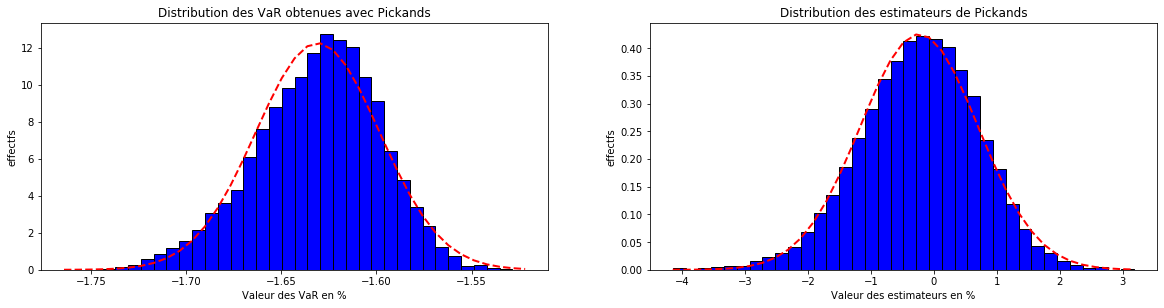

In [163]:
plt.figure(figsize=(20,10)) 


plt.subplot(222)
(mu, sigma) = norm.fit(random['Pickands_est'])
n, bins, patches = plt.hist(random['Pickands_est'], normed=1,color = 'blue',edgecolor = 'black',bins = int(180/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des estimateurs de Pickands")
plt.ylabel("effectfs")
plt.xlabel("Valeur des estimateurs en %")

plt.subplot(221)
(mu, sigma) = norm.fit(random['Var_Pick'])
n, bins, patches = plt.hist(random['Var_Pick'], normed=1,color = 'blue',edgecolor = 'black',bins = int(180/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des VaR obtenues avec Pickands")
plt.ylabel("effectfs")
plt.xlabel("Valeur des VaR en %")

Du côté des estimateurs de Pickands, ceux-ci suivent régulièrement une distribution normale. Cependant, on peut voir ici que selon les tirages, la distribution des VaR  sont peu similaires et ne suivent que pas toujours une loi normale. Même avec un coefficient de Hurst égal à 0 qui enlève toute autocorrélation.

Cela est assez étonnant du fait des propriétés du mouvement gaussien vu en cours : processus gaussien, d'espérance nulle et de premier terme égal à 0.

On pensait comme pour des rendements normaux revoir sortir une distribution parfaitement normale pour la VaR_99%. Cependant cela doit venir du peu de données utilisées.


#### 3.13. Represent in a graph the nonparametric VaR as a function of the bandwidth parameter of the kernel. Explain the method used to get this result.

L'object de cet exercice est de modéliser notre VaR pour ce titre en fonction du bandwidth, un paramètre de l'estimation de densité par noyaux.  Pour se faire : 
Le résultat final sera un graphique avec le paramètre bandwidth en abscisse et sa VaR asociée.

Nous retrouvons ici la distribution des rendements que nous étudions, contrasté par une loi normale.

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Valeur des rendements en %')

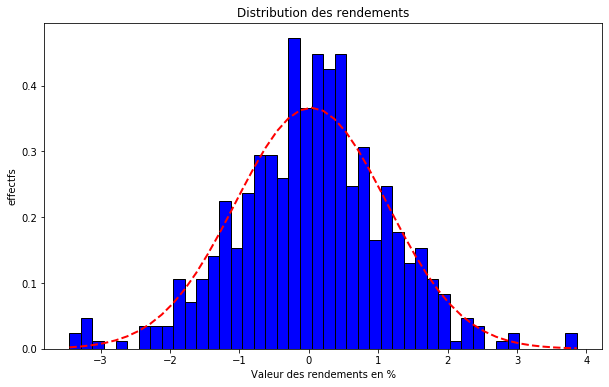

In [36]:
plt.figure(figsize=(10,6)) 
(mu, sigma) = norm.fit(db['Rendements'])
n, bins, patches = plt.hist(db['Rendements'], normed=1,color = 'blue',edgecolor = 'black',bins = int(220/5))
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Distribution des rendements")
plt.ylabel("effectfs")
plt.xlabel("Valeur des rendements en %")

Nous observons que nos rendements sont assez proches d'une loi normale. Nous allons donc essayer de modéliser nos rendements par l'estimation de densité par noyau gaussien

Il s'agit ici d'une estimation de notre série de rendement par noyau Gaussien. Le bandwidth est ici fixé à 0.3. C'est cette valeur que nous allons ici chercher à modifier.

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


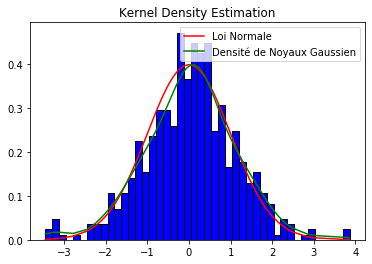

In [39]:
rendements = np.array(db["Rendements"])
gkde=stats.gaussian_kde(rendements,bw_method =0.3)

ind = sorted(np.array(db["Rendements"]))
kdepdf = gkde.evaluate(ind)

plt.figure()
# graph de l'histogramme des données
plt.hist(rendements,  normed=1,color = 'blue',edgecolor = 'black',bins = int(220/5))
# graph des données générant la densité
plt.plot(ind, stats.norm.pdf(ind), color="r", label='Loi Normale')
# graph de la densité estimée par noyau gaussien
plt.plot(ind, kdepdf, label='Densité de Noyaux Gaussien', color="g")
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

Pour obtenir notre VaR 99% par variation de brandwidth, nous créeons la fonction ci-dessous. Nous y fixons un bandwidthmin et max qui représenteront l'intervalle sur lequel le bandwidth variera. Celui variera par des pas de 0.01. Ainsi pour chaque bandwidth, la fonction ira calculer 1% de la densité de répartition du noyaux gaussien. La valeur placement retournée est l'indice de position du rendements associé que nous allons chercher dans l'objet "ind".

In [40]:
def VaR_KDE(val_min,val_max,pas):
    param_bandwidth = []
    VaR_99 = []
    for i in np.arange(val_min,val_max,pas):
        rendements = np.array(db["Rendements"])
        gkde=stats.gaussian_kde(rendements,bw_method = i)
        ind = sorted(np.array(db["Rendements"]))#np.linspace(-4,4,10000)
        kdepdf = gkde.evaluate(ind)
        limite = sum(kdepdf)*0.01
        placement = 0
        somme=0
        while somme < limite:
            somme += kdepdf[placement]
            placement += 1
        result = ind[placement]
        param_bandwidth.append(i)
        VaR_99.append(result)
    return pd.DataFrame(list(zip(param_bandwidth,VaR_99)), columns=['param_bandwidth','VaR_99'])

Nous utilisons ici la fonction pour calculer la VaR à 99% pour chaque bandwidth. Ceux-ci évoluent par pas de 0.01 entre 0.1 et 10.1

In [41]:
KDE_VaR = VaR_KDE(0.1,10.1,0.01)
KDE_VaR

,param_bandwidth,VaR_99
0,0.10,-1.64
1,0.11,-1.64
2,0.12,-1.64
3,0.13,-1.64
4,0.14,-1.64
...,...,...
995,10.05,-3.09
996,10.06,-3.09
997,10.07,-3.09
998,10.08,-3.09


Text(0, 0.5, 'VaR 99 %')

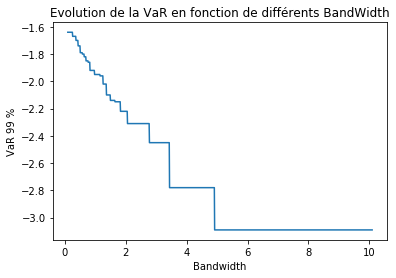

In [42]:
plt.plot(KDE_VaR["param_bandwidth"],KDE_VaR["VaR_99"])
plt.title("Evolution de la VaR en fonction de différents BandWidth")
plt.xlabel("Bandwidth")
plt.ylabel("VaR 99 %")

On voit que le graph est assez atypique, en marche d'escaliers, ce qui est assez normal, étant donné que la fonction marche par placement/position.Ainsi donc la VaR évouluera en pallier. Aussi, la mauvaise spécification du risque peut-être assez importante en fonction du choix du Bandwidth. En effet, la VaR est très différente entre un bandwidth proche de 0 et proche de 10.

Il est intéressant de remarquer que les propriétés géométriques du bandwidth font que la distribution (si le paramètre est négatif) est miroire

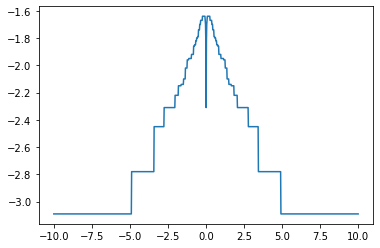

In [43]:
KDE_VaR2 = VaR_KDE(-10.02,10.02,0.02)
plt.plot(KDE_VaR2["param_bandwidth"],KDE_VaR2["VaR_99"])

## 4 Model risk as specification uncertainty

#### Question 14. Using the VaRs and ESs implemented in the first two sections, determine the diameter for VaRs as well as the diameter for ESs. Comment the result with respect to model risk: is it more relevant to use ES or VaR?

On récupère dans un premier temps un dictionnaire comprenant l'ensemble des valeurs de nos VaR et de nos ES.

In [52]:
def VaR_empirical(p,db):
    tri=db.sort_values(by=["Rendements"])
    NR=1-p
    min=int(round(db.shape[0]*NR,0))
    VaR_e = tri.iloc[min,3]
    return VaR_e
def VaR_normale(p,db):
    alpha=scipy.stats.norm.ppf(1-p)
    VaR_n = np.mean(db["Rendements"]) + alpha * np.std(db["Rendements"])
    return VaR_n
def VaR_non_para(db):
    valeur = 1000000
    simulation = np.random.normal(np.mean(db["Rendements"]), np.std(db["Rendements"]), valeur)
    Mte_carlo_VaR = np.percentile(simulation, 2)
    return Mte_carlo_VaR
def VaR_Pickands(p,db):
    VaR_pick= EVT(db,3,p)
    return VaR_pick
#ensemble des définitions de VaR (à p%) que l'on applique à un dataframe 
    

Calcul des ES en fonction des niveaux de nos VaR des deux premières parties et intégration du calcul de nos diamètres

In [87]:
def dict_VaR(p,df,db):
    df[f"VaR_{p}"]= [VaR_empirical(p,db), VaR_normale(p,db),VaR_non_para(db),VaR_Pickands(p,db)]
    moyenne=[]
    for i in df[f"VaR_{p}"].values:
        t= db[db["Rendements"] < i]["Rendements"] 
        moy= np.sum(t)/t.shape[0]
        moyenne.append(moy)
    df[f"ES_{p}"]=moyenne
    a= max(df[f"ES_{p}"])-df[f"ES_{p}"].min()
    b= max(df[f"VaR_{p}"])-df[f"VaR_{p}"].min()
    print(f"Le Diamètre de nos ES à un seuil de {p*100}% est de " + str(round(a,2)))
    print(f"Le Diamètre de nos VaR à un seuil de {p*100}% est de " + str(round(b,2)))
    return df



In [88]:
Quest4_14 =pd.DataFrame()
dict_VaR(0.99,Quest4_14,db)

Le Diamètre de nos ES à un seuil de 99.0% est de 0.41
Le Diamètre de nos VaR à un seuil de 99.0% est de 0.98


,VaR_0.99,ES_0.99
0,-3.155464,-3.279427
1,-2.501056,-3.177919
2,-2.208848,-2.892051
3,-3.190870,-3.304231


Le diamètre correspond à la différence entre la valeur maximale et la valeur minimale. L'ES est beaucoup plus stable que les VaR. Cela nous semble logique, puisque l'ES représente une moyenne et que la VaR est un point particulier. Les moyennes sont donc plus rapprochées entre les différentes méthodes que l'on a implementé. C'est un bon signe par rapport au travail fourni auparavant.

 On va donc préférer utiliser l'ES à la VaR, on a en effet plus de différences sur nos VaR que sur nos ES. Nous ne pouvons jamais être totalement certains du type de distribution de nos données (elles peuvent changer au cours du temps), donc l'ES est un meilleur choix car plus stable.

#### Question 15. Is your conclusion at Question 14 the same if you change the confidence level from 99% to 90%, 95%, 98%, 99.5%, 99.9%, and 99.99%?

In [89]:
Quest4_15=pd.DataFrame()
a=[0.9,0.95,0.98,0.99,0.995,0.999]
for i in a:
    dict_VaR(i,Quest4_15,db)


Le Diamètre de nos ES à un seuil de 90.0% est de 1.33
Le Diamètre de nos VaR à un seuil de 90.0% est de 1.85
Le Diamètre de nos ES à un seuil de 95.0% est de 0.9
Le Diamètre de nos VaR à un seuil de 95.0% est de 1.42
Le Diamètre de nos ES à un seuil de 98.0% est de 0.39
Le Diamètre de nos VaR à un seuil de 98.0% est de 0.97
Le Diamètre de nos ES à un seuil de 99.0% est de 0.41
Le Diamètre de nos VaR à un seuil de 99.0% est de 0.99
Le Diamètre de nos ES à un seuil de 99.5% est de 0.56
Le Diamètre de nos VaR à un seuil de 99.5% est de 1.18
Le Diamètre de nos ES à un seuil de 99.9% est de 0.56
Le Diamètre de nos VaR à un seuil de 99.9% est de 24.52


C:\Users\darai\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [90]:
Quest4_15

,VaR_0.9,ES_0.9,VaR_0.95,ES_0.95,VaR_0.98,ES_0.98,VaR_0.99,ES_0.99,VaR_0.995,ES_0.995,VaR_0.999,ES_0.999
0,-1.313321,-1.952897,-1.742498,-2.382615,-2.305857,-3.018109,-3.155464,-3.279427,-3.235139,-3.327261,-3.295572,-3.448276
1,-1.363305,-1.977422,-1.758930,-2.382615,-2.204204,-2.892051,-2.501056,-3.177919,-2.772733,-3.177919,-3.332902,-3.448276
2,-2.200814,-2.892051,-2.205772,-2.892051,-2.200592,-2.892051,-2.202440,-2.892051,-2.198000,-2.892051,-2.202431,-2.892051
3,-3.162712,-3.279427,-3.162934,-3.279427,-3.166398,-3.279427,-3.190870,-3.304231,-3.376350,-3.448276,-26.723628,NaN


On garde les mêmes conclusions pour tous les échantillons de paramètres. On observe cependant un problème. Pour une probabilité de 0.999, notre VaR estimé par pickands prend une trop forte valeur. Notre échantillon n'ayant pas de tel valeur, l'ES prend la valeur NaN.
Il faudra regarder plus en détail la VaR de pickands pour voir si il y a un problème.
Nous supposons pour le moment qu'il provient du manque de data.
Les conclusions précédentes sont vérifiées. Le diamètre de notre Expected-shortfall est toujours inférieure à celui de la value-at-risk pour l'ensemble des intervalles de confiance. (hormis le dernier intervalle de confiance où nos résultats sont faussés par le manque de données, plus on augmente l'intervalle de confiance, plus le diamètre semble diminuer)

####  Question 16. Add a noise process (say a Gaussian white noise) to the price return process and calculate the average impact on the VaR for each model. Which VaR method is the most robust? Display your results for various amplitudes of noise.

Un bruit blanc gaussien est un bruit (réalisation d'un processus totalement aléatoire) qui suit une loi normale de variance et de moyenne donnée. On va créer dans un premier temps une fonction qui ajoute du bruit à notre base de données. Pour se faire on prend chacun de nos rendements auquel on ajoute un bruit aléatoire (random) gaussien de moyenne que l'on fixera nul (il sera intéressant de varier ce paramètre, donc je le laisse dans la fonction), et de l'amplitude (std: représentant la variance du bruit). Cette même fonction nous donnera les graphes des rendements bruités

In [102]:
db2=db.copy(deep=True)

In [103]:
def Noise(mean,std,data):
    rdt=data["Rendements"].astype(float)
    num_samples = len(data)
    for i in rdt:
        data["Rendements"]=rdt+np.random.normal(mean, std, size=num_samples)
    plt.figure(figsize=(20,10)) 
    plt.plot(data["Rendements"])
    plt.plot(db["Rendements"])
    plt.legend(["donnée_bruitée", "donnée_initiale"])
    plt.ylabel("Rendements")
    plt.xlabel("Time")
    plt.show()
 

In [104]:
#Noise(0,100)
#bcp trop de bruit, se voit à l'échelle, normal, on a des rdt en %

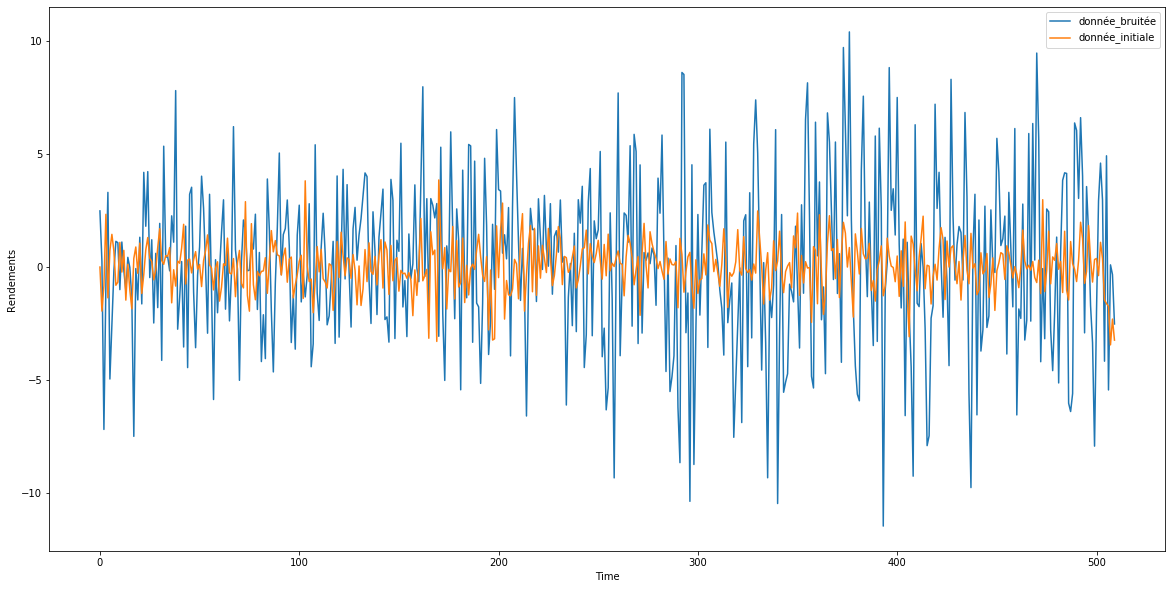

In [123]:
Noise(0,3,db2)

Que ce soit sur l'array ou sur le graphique, mettre une amplitude de 3 nous ajoute beaucoup de bruits, le maximum et le minimum de nos rendements ont été multiplié par 2 voire 3 fois leur valeur initiale. Nous faisons attention de stocker nos données pour la suite de l'exercide dans des dataframes. Ici db2

In [106]:
 db2.head() #on observe bien un changement de nos rendements...

,Ref,Date,Prix_Action,Rendements,Volume
0,FR0000125486,2018-03-01,81.00,2.522865,1634512
1,FR0000125486,2018-03-02,79.42,-4.806294,1955518
2,FR0000125486,2018-03-05,78.76,-0.348424,1205915
3,FR0000125486,2018-03-06,80.60,6.661245,1181287
4,FR0000125486,2018-03-07,79.50,-3.111334,1268385


On va maintenant réutiliser nos VaR pour voir la différence avec les questions précédentes

In [107]:
def dict_VaR2(p,df,db):
    df[f"VaR_{p}"]= [VaR_empirical(p,db), VaR_normale(p,db),VaR_non_para(db),VaR_Pickands(p,db)]
    return df

In [108]:
Quest4_16=pd.DataFrame()
dict_VaR2(0.99,Quest4_16,db2)

,VaR_0.99
0,-8.487420
1,-7.479694
2,-6.594534
3,-8.637229


En prenant une amplitude de 3, nous remarquons bien que notre volatilité de nos rendements est fortement bruité. Nos VaR, sont fortement impacté à la baisse. Avec un tel bruit, on ne peut pas considérer la var empirique comme solution viable (les données sont bien trop aléatoire, aucune utilité de l'utiliser). Les bruits suivants une loi gausienne, je prendrai plutôt une loi non paramètrique, car il y a trop d'instabilité. (pas une loi paramétrique car nous supposions que ce sont nos rendements qui suivent une loi normale... pas d'hypothèse sur le bruit). Ce serait la VaR à -6.5 dans notre cas

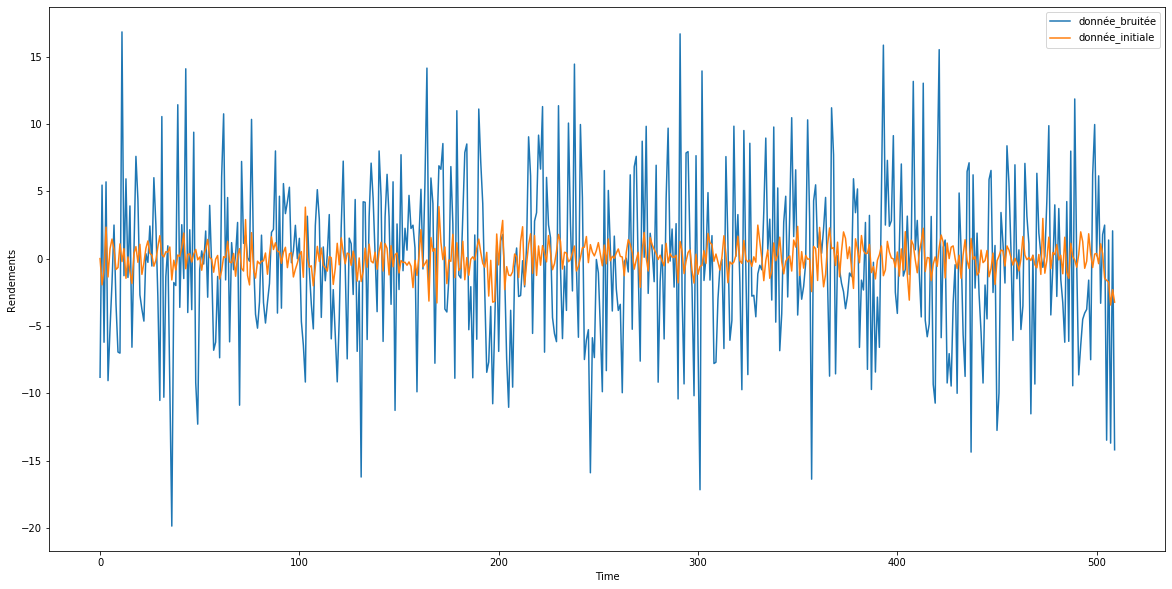

,VaR_0.99
0,-14.371455
1,-14.394794
2,-12.714774
3,-16.095538


In [109]:
db3=db.copy(deep=True)
Quest4_16b=pd.DataFrame()
Noise(0,6,db3)
dict_VaR2(0.99,Quest4_16b,db3)

Toutes nos VaR sont bien instables à cause du bruit, en augmentant sont amplitiudes, elles sont plus à la baisse. Il serait intéressant de calculer l'impact d'une variation de l'amplitude sur nos VaR (c'est à dire les dérivées par rapport à p)

#### Question 17. Remove the noise of the price return process using the projection of your signal at one scale. Do this with scaling functions (also called father wavelet).

L'objectif est de reprendre une série avec du bruit, et de le retirer. Pour cela on devrait utiliser des ondelettes. Elle séparare les différents signal de notre base de rendements. Ici, elle aura pour but de trouver la partie aléatoire de notre série et de la séparer de la partie initiale. Mais dans d'autres cas, elle servira à séparer un trend d'une série, une tendance saisonnière... Concrétement, on va utiliser la méthode par escalier (haar) car c'est bien plus simple qu'une daubechies. Ayant échoué à la coder par nous même, nous avons utilisé la librairie pywt grâce à notre ami Google. (nous avons trouvé la fonction haar si dessous dans lequel nous avons testé différents paramètrages pour l'optimiser au mieux). Nous avons ensuite nous-même représenter la série débruitée avec celle initiale pour mieux les comparer. Nos résultats sont instables et peuvent changer en les relançant. Nous avons vu à certains moments que notre fonction haar capté une sorte de tendance saisonnière (en semestre), la série débruitée était plutôt plate sur les périodes correspondant à l'été. Cela dépend d'abord du bruit, mais comme nous n'avons dans ce cadre posé aucune hypothèse sur la temporalité dans notre exercice, il peut y avoir d'autres signaux. Hors nos rendements peuvent avoir des saisonnalités et des trends. Mais comme notre base comporte que des odnnées de 2 années, nous nous attarderons pas dessus.

In [110]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

Optimisation de notre fonction haar (wavelet choisi dans le cadre de cet exercice). Nous avons trouvé la fonction, nous avons testé pour bon nombre de paramètres pour la faire tourner (ce qui fut initialement compliquer). Augmenter le nombre de level va accroître le découpage de la data initiale, on cherche ici seulement à décorréler le bruit de notre data, on va fixer le level à 1 et ne pas tenir compte d'autres signaux pouvant exister.

In [116]:
##fonction que l'on a trouvé à l'aide internet, un ptit modifié pour tourner au mieux sur notre échantillon (paramètre de scaling)
def haar ( data_à_débruiter, level, s=0.3 ):

    #s est un paramètre de scaling: on a fait plusieurs itérations pour trouver son optimum
    h = [ 1,  1 ];           # lowpass filter
    g = [ 1, -1 ];           # highpass filter        
    f = len ( h );           # length of the filter
    # en changeant un petit peu les paramètres de filtre, on ne voit pas de grandes différences, on a donc laissé 
    #les paramètres de base
    t = data_à_débruiter;              # 'workspace' array
    l = len ( t );           # length of the current signal
    y = [0] * l;             # initialise output

    for i in range ( level ): 
        y [ 0:l ] = [0] * l; # initialise the next level 
        l2 = l // 2;         # half approximation, half detail

        for j in range ( l2 ):            
            for k in range ( f ):                
                y [j]    += t [ 2*j + k ] * h [ k ] * s;
                y [j+l2] += t [ 2*j + k ] * g [ k ] * s;

        l = l2;              # continue with the approximation
        t [ 0:l ] = y [ 0:l ] ;
    return y

Création d'une fonction nous donnant les données bruitées, débruitées et initiales

In [124]:
def Data_bruit():
    données_bruitées = db2["Rendements"].values; #données bruitées
    données_débruitées= haar (db2["Rendements"].values, 1) 
    données_initiale= db["Rendements"]
    return données_bruitées, données_débruitées, données_initiale
rdt_bruitées,rdt_débruitées,rdt_initiaux =Data_bruit()


Représentation graphiques de nos données_débruitées et de données initiales

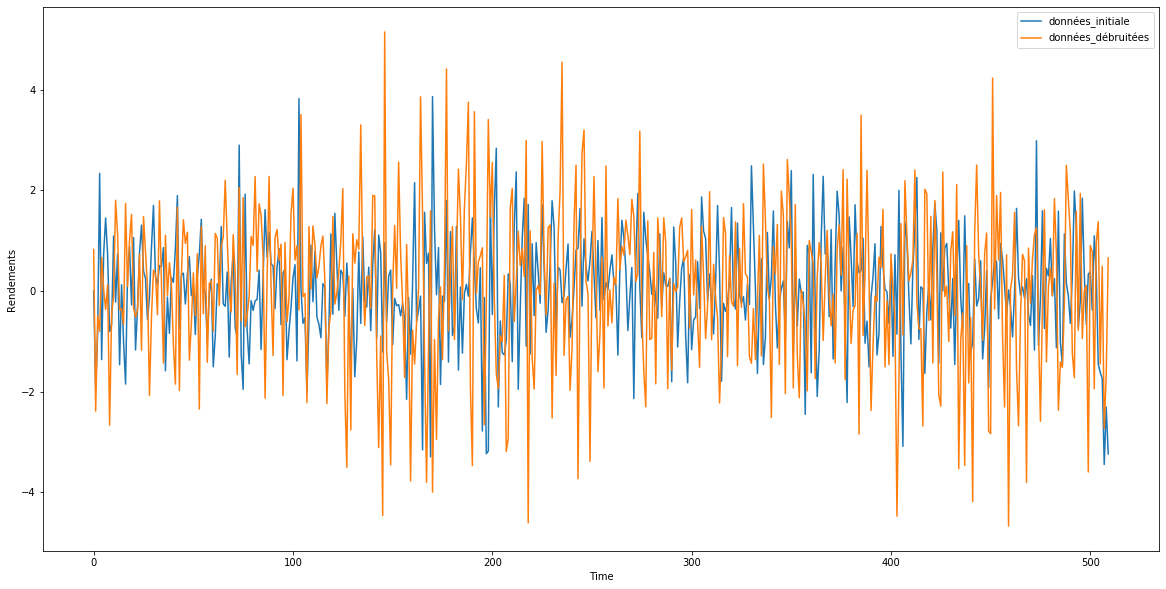

In [125]:
plt.figure(figsize= (20, 10))
plt.plot(rdt_initiaux)
plt.plot(rdt_débruitées)
plt.ylabel("Rendements")
plt.xlabel("Time")
plt.legend(["données_initiale", "données_débruitées"])

Notre série débruitée semble fonctionner par saisonnalité parfois: en la relaçant plusieurs fois, on obtient  des tendances saisonnières (1 fois sur 3). Nous avons appliqué un bruit trop fort. La fonction a dans ces cas là du mal à déterminer les signaux. Mais comparativement au graphe précédent, on se rapproche beaucoup de nos données initiales, nous en sommes satisfaits, malgré la partie aléatoire de ce rendement.

Nous savons bien que cette partie aléatoire n'est pas le résultat idéal mais nous allons quand même continuer sur la question 18. Idéalement, nous pensions que cette fonciton allait capter seulement le signal bruit blanc que l'on a ajouté à notre data. Mais je pense sérieusement qu'il doit y avoir un effet de trend ou de saisonnalité sur notre data qu'il faudrait analyser.

#### Question 18. How do your VaR measures vary if they are applied to the denoised series? Display your results for various projection scales. Compare qualitatively your results with the ones of Question 16

Pour cette question, on va réutiliser les fonctions du début de la partie 4 que nous avions créé. Nous allons changer la base db par notre base (b) représentant les données bruitées

In [127]:
Quest18=pd.DataFrame()
db18=db.copy()
db18["Rendements"]=rdt_débruitées
dict_VaR(0.99,Quest18,db18)


Le Diamètre de nos ES à un seuil de 99.0% est de 0.71
Le Diamètre de nos VaR à un seuil de 99.0% est de 1.09


,VaR_0.99,ES_0.99
0,-3.995973,-4.480017
1,-3.607366,-4.151268
2,-3.180474,-3.839646
3,-4.271270,-4.553905


Nous remarquons ici un point très intéressant, l'écart entre nos diamètres s'est réduit. Mais les conclusions ne changent pas. Nous supposions qu'avec l'utilisation de nos données le diamètre des ES seraient plus importants, car graphiquement on semble observer plus de volatilité à la perte (ce qui doit forcement impacter la moyenne des rendements les plus faibles).


In [128]:
#Nous allons maintenant changer de scale, et prendre notre dataframe db3 qui a une amplitude deux fois supérieure maintenant
bruit,debruit,data_initiale =Data_bruit()


In [129]:
Quest18b=pd.DataFrame()
db18b=db.copy()
db18b["Rendements"]=debruit
dict_VaR(0.99,Quest18b,db18b)


Le Diamètre de nos ES à un seuil de 99.0% est de 0.82
Le Diamètre de nos VaR à un seuil de 99.0% est de 1.39


,VaR_0.99,ES_0.99
0,-3.995973,-4.480017
1,-3.262769,-3.901316
2,-2.884526,-3.729735
3,-4.271270,-4.553905


En augmentant notre amplitude (du bruit ajouté) sur notre série, on remarque une plus grande instabilité encore que précédemment sur nos diamètres. Les conclusions sont d'ailleurs différentes, ici il est préférable d'utiliser l'ES qui est plus stable. Mais les deux diagrammes ont fortmeent augmenté avec l'accroît du bruit.